<a href="https://colab.research.google.com/github/kkrusere/youTube-comments-Analyzer/blob/main/YT_comments_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os

#mounting google drive
drive.mount('/content/drive')

########################################

#changing the working directory
os.chdir("/content/drive/MyDrive/EV NLP Data")

!pwd


Mounted at /content/drive
/content/drive/MyDrive/EV NLP Data


## **Building a Deep Learning Sentiment Analysis Model with YouTube Comments**

we are going to do transfer-learning first and see the perfomance of the model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

import json

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
# Function to save comments data to a JSON file
def save_comments_to_json(comments, filename = 'youtube_comments.json'):
    with open(filename, 'w') as json_file:
        json.dump(comments, json_file, indent=4)

def load_comments_from_json(filename = 'youtube_comments.json'):
    with open(filename, 'r') as json_file:
        comments = json.load(json_file)
    return comments

In [4]:
comments_data = load_comments_from_json()

In [5]:
# Load the JSON data into a Pandas DataFrame
comments_data_df = pd.DataFrame(comments_data)

comments_data_df.head()


,comment_text,like_count,reply_count
0,A major obstacle to EV adoption that is always...,6K,507 replies
1,A major obstacle to EV adoption that is always...,6K,507 replies
2,"Prices are too high, and dealerships keep addi...",3.9K,216 replies
3,The government isn’t fast enough to patch poth...,89,6 replies
4,We have the coldest winters in many years here...,34,1 reply


In [ ]:
comments_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16477 entries, 0 to 16476
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  15427 non-null  object
 1   like_count    15427 non-null  object
 2   reply_count   4204 non-null   object
dtypes: object(3)
memory usage: 386.3+ KB


In [6]:
comments_data_df['comment_text_cleaned'] = None
comments_data_df.head()

,comment_text,like_count,reply_count,comment_text_cleaned
0,A major obstacle to EV adoption that is always...,6K,507 replies,None
1,A major obstacle to EV adoption that is always...,6K,507 replies,None
2,"Prices are too high, and dealerships keep addi...",3.9K,216 replies,None
3,The government isn’t fast enough to patch poth...,89,6 replies,None
4,We have the coldest winters in many years here...,34,1 reply,None


In [7]:
# Drop null values in the `comment_text ` column
comments_data_df = comments_data_df.dropna(subset=['comment_text'])
# Drop duplicates if there are any in the `comment_text ` column
comments_data_df = comments_data_df.drop_duplicates(subset='comment_text')




In [8]:
comments_data_df.to_csv('youtube_comments_cleaned.csv', index=False)

In [9]:
comments_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14343 entries, 0 to 14342
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   comment_text          14343 non-null  object
 1   like_count            14343 non-null  object
 2   reply_count           3906 non-null   object
 3   comment_text_cleaned  14343 non-null  object
dtypes: object(4)
memory usage: 448.3+ KB


In [10]:
comments_data_df.head()

,comment_text,like_count,reply_count,comment_text_cleaned
0,A major obstacle to EV adoption that is always...,6K,507 replies,major obstacle ev adoption always overlooked i...
1,"Prices are too high, and dealerships keep addi...",3.9K,216 replies,prices high dealerships keep adding dealership...
2,The government isn’t fast enough to patch poth...,89,6 replies,government isn’t fast enough patch potholes ro...
3,We have the coldest winters in many years here...,34,1 reply,coldest winters many years scandinavia places ...
4,"Im not fond of Tesla, but I do like the fact t...",6K,411 replies,im fond tesla like fact theyve steadily slashi...


In [ ]:
# Lowercase the text
comments_data_df['comment_text_cleaned'] = comments_data_df['comment_text'].str.lower()
# Remove punctuation
comments_data_df['comment_text_cleaned'] = comments_data_df['comment_text_cleaned'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

# Remove stop words
stop_words = stopwords.words('english')
comments_data_df['comment_text_cleaned'] = comments_data_df['comment_text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


#reset dataframe index
comments_data_df.reset_index(inplace=True, drop=True)

In [ ]:
random_comments = comments_data_df.sample(n=1000)
random_comments = random_comments.reset_index(drop=True)
random_comments.head()

,comment_text,like_count,reply_count,comment_text_cleaned
0,I think one the biggest problems dealership ar...,21,5 replies,think one biggest problems dealership problems...
1,EVs like all appliances have their pros and co...,1,None,evs like appliances pros cons amazing short ti...
2,Love this information. Thank you for posting,,None,love information thank posting
3,Hybrids are the way to go for now. Hydrogen is...,,None,hybrids way go hydrogen future opinion scrap y...
4,Well better than porsche i dont think so.,,None,well better porsche dont think


In [ ]:
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Apply stemming to the comments
random_comments['clean_comment_stemmed'] = random_comments['comment_text'].apply(lambda x: [stemmer.stem(word) for word in x.split()])
random_comments['clean_comment_stemmed_str'] = random_comments['clean_comment_stemmed'].apply(' '.join)

In [ ]:
# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()
# Apply lemmatization to the comments
random_comments['clean_comment_lemmatized'] = random_comments['comment_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x.split()])
random_comments['clean_comment_lemmatized_str'] = random_comments['clean_comment_lemmatized'].apply(' '.join)



In [ ]:
random_comments.head()

,comment_text,like_count,reply_count,comment_text_cleaned,clean_comment_stemmed,clean_comment_stemmed_str,clean_comment_lemmatized,clean_comment_lemmatized_str
0,I think one the biggest problems dealership ar...,21,5 replies,think one biggest problems dealership problems...,"[i, think, one, the, biggest, problem, dealers...",i think one the biggest problem dealership are...,"[I, think, one, the, biggest, problem, dealers...",I think one the biggest problem dealership are...
1,EVs like all appliances have their pros and co...,1,None,evs like appliances pros cons amazing short ti...,"[ev, like, all, applianc, have, their, pro, an...",ev like all applianc have their pro and cons. ...,"[EVs, like, all, appliance, have, their, pro, ...",EVs like all appliance have their pro and cons...
2,Love this information. Thank you for posting,,None,love information thank posting,"[love, thi, information., thank, you, for, post]",love thi information. thank you for post,"[Love, this, information., Thank, you, for, po...",Love this information. Thank you for posting
3,Hybrids are the way to go for now. Hydrogen is...,,None,hybrids way go hydrogen future opinion scrap y...,"[hybrid, are, the, way, to, go, for, now., hyd...",hybrid are the way to go for now. hydrogen is ...,"[Hybrids, are, the, way, to, go, for, now., Hy...",Hybrids are the way to go for now. Hydrogen is...
4,Well better than porsche i dont think so.,,None,well better porsche dont think,"[well, better, than, porsch, i, dont, think, so.]",well better than porsch i dont think so.,"[Well, better, than, porsche, i, dont, think, ...",Well better than porsche i dont think so.


In [ ]:
!pip install kmodes

In [ ]:
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def plot_silhouette_scores(cluster_range, silhouettes):
  # Plot the silhouette scores
  plt.figure(figsize=(12, 4))

  plt.plot(cluster_range, silhouettes, marker='o')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Silhouette Score')
  plt.title('Silhouette Score vs. Number of Clusters')

def plot_WCSS(cluster_range, wcss):
  # Plot the within-cluster sum of squares
  plt.figure(figsize=(12, 4))
  plt.plot(cluster_range, wcss, marker='o')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
  plt.title('WCSS vs. Number of Clusters')

  # Finding the elbow point
  x = list(cluster_range)
  y = wcss
  k = 3
  y_eps = 0.01
  elbow_point = None
  for i in range(1, len(y) - k):
      prev_slope = (y[i] - y[i - 1]) / (x[i] - x[i - 1])
      next_slope = (y[i + k] - y[i + k - 1]) / (x[i + k] - x[i + k - 1])
      if abs(next_slope - prev_slope) / abs(prev_slope) < y_eps:
          elbow_point = (x[i], y[i])
          break

  if elbow_point:
      plt.plot(elbow_point[0], elbow_point[1], marker='o', markersize=8, color='red', label='Elbow Point')
      plt.legend()

  plt.show()


In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(random_comments['comment_text_cleaned'])
X = X.toarray()

# Initialize KModes clustering with 5 clusters
km = KModes(n_clusters=5, init='Huang', n_init=5, verbose=1)
# Fit the clustering model to the data
km.fit(X)



Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 887, cost: 19133.0
Run 1, iteration: 2/100, moves: 0, cost: 19133.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 166, cost: 18815.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 85, cost: 18930.0
Run 3, iteration: 2/100, moves: 3, cost: 18930.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 20, cost: 19137.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 104, cost: 18879.0
Best run was number 2


KModes(init='Huang', n_clusters=5, n_init=5, verbose=1)

In [ ]:
from joblib import Parallel, delayed

def kmodes_clustering(data, cluster_range):
    # Vectorize comments
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data)
    X = X.toarray()

    # Initialize empty lists to store the silhouette scores and kmodes models
    silhouettes = []
    kmodes_models = []
    wcss = []

    def fit_kmodes(n_clusters):
        print(f"Fitting k-modes with {n_clusters} clusters...")
        kmodes = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=1)
        # Fit the k-modes model
        kmodes.fit(X)
        print(f"Silhouette score for {n_clusters} clusters: {silhouette_score(X, kmodes.labels_)}")
        wcss.append(kmodes.cost_)
        kmodes_models.append(kmodes)
        labels = kmodes.labels_
        silhouette_avg = silhouette_score(X, labels)
        silhouettes.append(silhouette_avg)

    Parallel(n_jobs= 5)(delayed(fit_kmodes)(n_clusters) for n_clusters in cluster_range)

    return silhouettes, wcss


In [ ]:
# prompt: parallel computing for kmodes clustering

from joblib import Parallel, delayed

def kmodes_clustering(data, cluster_range):
    # Vectorize comments
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data)
    X = X.toarray()
    print("we are here")

    # Initialize empty lists to store the silhouette scores and kmodes models
    silhouettes = []
    kmodes_models = []
    wcss = []

    def fit_kmodes(n_clusters):
        print(f"Fitting k-modes with {n_clusters} clusters...")
        kmodes = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=1)
        # Fit the k-modes model
        kmodes.fit(X)
        print(f"Silhouette score for {n_clusters} clusters: {silhouette_score(X, kmodes.labels_)}")
        wcss.append(kmodes.cost_)
        kmodes_models.append(kmodes)
        labels = kmodes.labels_
        silhouette_avg = silhouette_score(X, labels)
        silhouettes.append(silhouette_avg)
    print("we got to here")
    # Use parallel processing to fit k-modes models for each number of clusters
    Parallel(n_jobs= -1)(delayed(fit_kmodes)(n_clusters) for n_clusters in cluster_range)

    return silhouettes, wcss


In [ ]:
cluster_range = range(2, 10)

silhouettes, wcss = kmodes_clustering(random_comments['comment_text_cleaned'], cluster_range)


we are here
we got to here


KeyboardInterrupt: 

In [ ]:
random_comments['comment_text_cleaned']

0      think one biggest problems dealership problems...
1      evs like appliances pros cons amazing short ti...
2                         love information thank posting
3      hybrids way go hydrogen future opinion scrap y...
4                         well better porsche dont think
                             ...                        
995                                  didnt age great lol
996    much emphasis rapid charging 2 electric cars r...
997    shove things peoples throatits never good thin...
998    drive plug great usual usage 40 miles day exce...
999    another added ev cost tires tyres apparently s...
Name: comment_text_cleaned, Length: 1000, dtype: object

In [ ]:
wcss

[]

ValueError: x and y must have same first dimension, but have shapes (8,) and (0,)

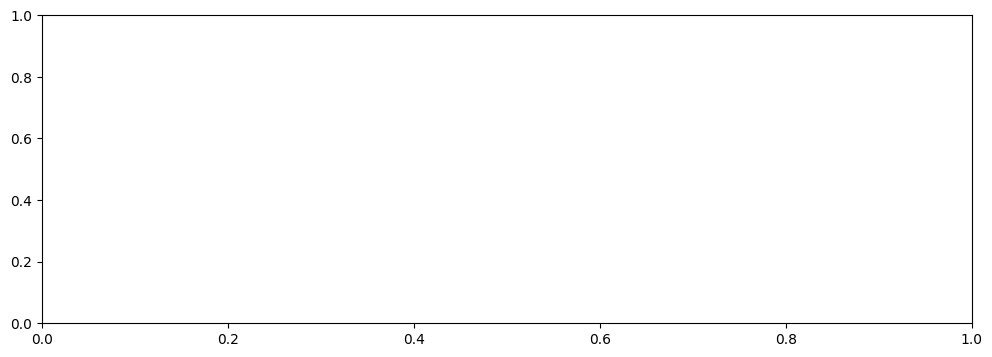

In [ ]:
plot_silhouette_scores(cluster_range, silhouettes)
plot_WCSS(cluster_range, wcss)

In [ ]:
cluster_range = range(2, 10)

silhouettes, wcss = kmodes_clustering(comments_data_df['comment_text_stemmed'], cluster_range)

In [ ]:
plot_silhouette_scores(cluster_range, silhouettes)
plot_WCSS(cluster_range, wcss)

In [ ]:
cluster_range = range(2, 10)

silhouettes, wcss = kmodes_clustering(comments_data_df['comment_text_lemmatized'], cluster_range)

In [ ]:
plot_silhouette_scores(cluster_range, silhouettes)
plot_WCSS(cluster_range, wcss)